<a href="https://colab.research.google.com/github/Manti-code/classification-predict-streamlit-template/blob/master/Copy_of_Text_classification_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Introduction

Earth's global surface temperature in 2018 was the fourth warmest since 1880. The global average temperature has increased by +1.1°C since the pre-industrial period. The global mean sea-level rise has amounted to 5 mm per year
Ninety (90) percent of the excess heat caused by climate change is stored in the oceans. More than 90 % of the natural disasters are related to weather

With this in mind, many companies are built around lessening one’s environmental impact or carbon footprint. They offer products and services that are environmentally friendly and sustainable, in line with their values and ideals. They would like to determine how people perceive climate change and whether or not they believe it is a real threat. This would add to their market research efforts in gauging how their product/service may be received.

## 2. Problem Statement

Create a model that determines whether or not a person believes in climate change or not based on their tweet

## 3. Data Preprocessing and Cleaning

### 3.0 Data requirements

The collection of this data was funded by a Canada Foundation for Innovation JELF Grant to Chris Bauch, University of Waterloo. The dataset aggregates tweets pertaining to climate change collected between Apr 27, 2015 and Feb 21, 2018. In total, 43943 tweets were collected. Each tweet is labelled as one of the following classes:

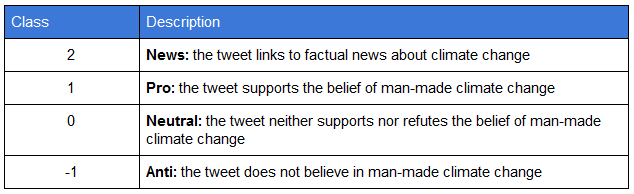

#### Variable definitions

sentiment: Sentiment of tweet
message: Tweet body
tweetid: Twitter unique id

#### Files used

train.csv (15819 rows) to train the model

test.csv (10546 rows) to test the model

### 3.1 Imports

In [ ]:
#connecting to a cloud based ML platform
from comet_ml import Experiment
exp = Experiment(api_key='zT5wdVotP48X3ZqsYMXW7GAXZ',
                 project_name='sklearn-demos',
                 auto_param_logging=False)

# storing and analysis
import numpy as np
import pandas as pd
import re

# visualization
import matplotlib.pyplot as plt
import warnings
import nltk
import string
import seaborn as sns

#import text classification modules
import os
from nltk.tokenize import WordPunctTokenizer
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
#from textblob import TextBlob
from nltk.stem.porter import * 
from wordcloud import WordCloud
import spacy
from spacy import displacy
from spacy.lang.en.stop_words import STOP_WORDS
from sklearn.feature_extraction.text import TfidfVectorizer

# import train/test split module
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

# import scoring metrice
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# suppress cell warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In order to perform sentiment analysis precisely, we need to clean the original text first. In this section, we will remove usernames start with the sign '@', remove hyperlinks start with http:// and www, and uncontract the negatives. After the cleaning, we will drop the stopwords and tokenize every tweet to get things ready for the analysis.

### 3.2 Load the dataset

In [ ]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

### 3.3 Data Preprocessing

In [ ]:
#Combining both Train and Test Data Set before data cleaning as tweets in both the data set is unstructured
data = df_train.append(df_test, ignore_index=True)

 #### 3.3.1 Remove Twitter Handles (@user)

Twitter handles are masked as @user due to concerns surrounding privacy. Thus, twitter handles do note necessarily give necessary information around the overall tweet. Thus we will remove them

In [ ]:
#remove twitter handles
def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i, '', input_txt)
        
    return input_txt   

In [ ]:
# remove twitter handles (@user)
data['tidy_message'] = np.vectorize(remove_pattern)(data['message'], "@[\w]*")

In [ ]:
data.head()

,sentiment,message,tweetid,tidy_message
0,1.0,PolySciMajor EPA chief doesn't think carbon di...,625221,PolySciMajor EPA chief doesn't think carbon di...
1,1.0,It's not like we lack evidence of anthropogeni...,126103,It's not like we lack evidence of anthropogeni...
2,2.0,RT @RawStory: Researchers say we have three ye...,698562,RT : Researchers say we have three years to ac...
3,1.0,#TodayinMaker# WIRED : 2016 was a pivotal year...,573736,#TodayinMaker# WIRED : 2016 was a pivotal year...
4,1.0,"RT @SoyNovioDeTodas: It's 2016, and a racist, ...",466954,"RT : It's 2016, and a racist, sexist, climate ..."


#### 3.3.2 Remove Punctuation, special characters and Numbers

With regards to punctuation, special characters and numbers, many if not all of them do not change or determine the over all sentiment of a tweet. Thus, it is important to remove these from the tweets

In [ ]:
# remove special characters, numbers, punctuations
data['tidy_message'] = data['tidy_message'].str.replace("[^a-zA-Z#]", " ")

#### 3.3.3 Removing short words

A vast majoity of short words which are less than 3 letters long generatlly do not add much information surrounding the sentiment. Words like 'ohh' and 'lol' do not give us much information, thus important to remove them

In [ ]:
#remove short words of less than 3 letters in length
data['tidy_message'] = data['tidy_message'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))

In [ ]:
data.head()

,sentiment,message,tweetid,tidy_message
0,1.0,PolySciMajor EPA chief doesn't think carbon di...,625221,PolySciMajor chief doesn think carbon dioxide ...
1,1.0,It's not like we lack evidence of anthropogeni...,126103,like lack evidence anthropogenic global warming
2,2.0,RT @RawStory: Researchers say we have three ye...,698562,Researchers have three years climate change be...
3,1.0,#TodayinMaker# WIRED : 2016 was a pivotal year...,573736,#TodayinMaker# WIRED pivotal year climate chan...
4,1.0,"RT @SoyNovioDeTodas: It's 2016, and a racist, ...",466954,racist sexist climate change denying bigot lea...


#### 3.3.4 Tokenization

Tokenization is the process of tokenizing or splitting a string, text into a list of tokens. One can think of token as parts like a word is a token in a sentence, and a sentence is a token in a paragraph.
Now we will tokenize all the cleaned tweets in our dataset. Tokens are individual terms or words, and tokenization is the process of splitting a string of text into tokens.

In [ ]:
#Tokenization
tokenized_tweet = data['tidy_message'].apply(lambda x: x.split())
tokenized_tweet.head()

0    [PolySciMajor, chief, doesn, think, carbon, di...
1    [like, lack, evidence, anthropogenic, global, ...
2    [Researchers, have, three, years, climate, cha...
3    [#TodayinMaker#, WIRED, pivotal, year, climate...
4    [racist, sexist, climate, change, denying, big...
Name: tidy_message, dtype: object

#### 3.3.5 Stemming

Stemming is a rule-based process of stripping the suffixes (“ing”, “ly”, “es”, “s” etc) from a word. For example, For example – “play”, “player”, “played”, “plays” and “playing” are the different variations of the word – “play”.

In [ ]:
from nltk.stem.porter import *
stemmer = PorterStemmer()

tokenized_tweet = tokenized_tweet.apply(lambda x: [stemmer.stem(i) for i in x]) # stemming
tokenized_tweet.head()

0    [polyscimajor, chief, doesn, think, carbon, di...
1        [like, lack, evid, anthropogen, global, warm]
2    [research, have, three, year, climat, chang, b...
3    [#todayinmaker#, wire, pivot, year, climat, ch...
4    [racist, sexist, climat, chang, deni, bigot, l...
Name: tidy_message, dtype: object

We will now bring the tokens back together

In [ ]:
for i in range(len(tokenized_tweet)):
    tokenized_tweet[i] = ' '.join(tokenized_tweet[i])

data['tidy_message'] = tokenized_tweet

## 4. Explanatory Data Analysis

### 4.1 Analysis of sentiment

We will now split the data back to training set and test set in order to get the overall sentiment on climate change around the tweets we have in our training data

In [ ]:
train = data.iloc[:len(df_train)]
test = data.iloc[len(df_train):]

In [ ]:
train['sentiment'].value_counts()

 1.0    8530
 2.0    3640
 0.0    2353
-1.0    1296
Name: sentiment, dtype: int64

Using the value_counts() method we can already see that there lies a strong sentiment in our training set on positive sentiment around the climate change, which will be confirmed in the below diagram. More than 50% of people on twitter, according to twitter are spreading positive news around climate change followed by the news publications. We will further investigate what the positive sentiments are, followed by the news and the negative sentiments

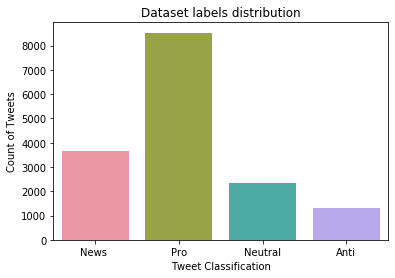

No of Tweets labelled as News: 3640
No of Tweets labelled as Pro: 8530
No of Tweets labelled as Neutral: 2353
No of Tweets labelled as Anti: 1296
Data is unbalanced with only 23.01 % news tweets, 53.92 % (pro)positive tweets, 14.87 % neutral tweets and 8.19 % (anti)negative tweets


In [ ]:
News = train['sentiment'].value_counts()[2]
Pro= train['sentiment'].value_counts()[1]
Neutral=train['sentiment'].value_counts()[0]
Anti=train['sentiment'].value_counts()[-1]

flatui = ["#15ff00", "#ff0033"]
sns.set_palette(flatui)
sns.barplot(['News ','Pro','Neutral','Anti'],[News,Pro,Neutral,Anti])
plt.xlabel('Tweet Classification')
plt.ylabel('Count of Tweets')
plt.title('Dataset labels distribution')
plt.show()

print('No of Tweets labelled as News:',News)
print('No of Tweets labelled as Pro:',Pro)
print('No of Tweets labelled as Neutral:',Neutral)
print('No of Tweets labelled as Anti:',Anti)

print('Data is unbalanced with only',round(((News/(News+Pro+Neutral+Anti))*100),2),'% news tweets,',
      round(((Pro/(Pro+News+Neutral+Anti))*100),2),'% (pro)positive tweets,',round(((Neutral/(Neutral+Pro+News+Anti))*100),2),'% neutral tweets and',
      round(((Anti/(Anti+Neutral+News+Pro))*100),2),'% (anti)negative tweets')

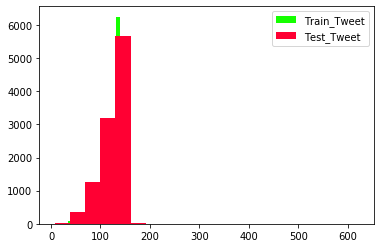

In [ ]:
#Check the Distribution of Length of Tweets in train and Test Dataset
tweetLengthTrain = train['message'].str.len()
tweetLengthTest = test['message'].str.len()

plt.hist(tweetLengthTrain,bins=20,label='Train_Tweet')
plt.hist(tweetLengthTest,bins=20,label='Test_Tweet')
plt.legend()
plt.show()

From the plot above,it can be observed that the train and test datasets have almost the same length of tweets.

In [ ]:
train['message_length'] = train['message'].apply(len)

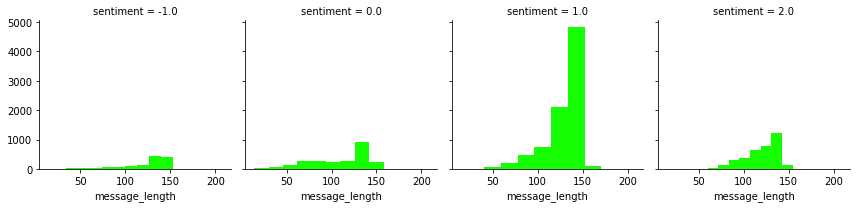

In [ ]:
g = sns.FacetGrid(train,col='sentiment')
g.map(plt.hist,'message_length')

The above FacetGrid indicates the positive sentiment has generally longer tweet length than the rest of the sentiment, followed by the news and the least length is the negative sentiment.

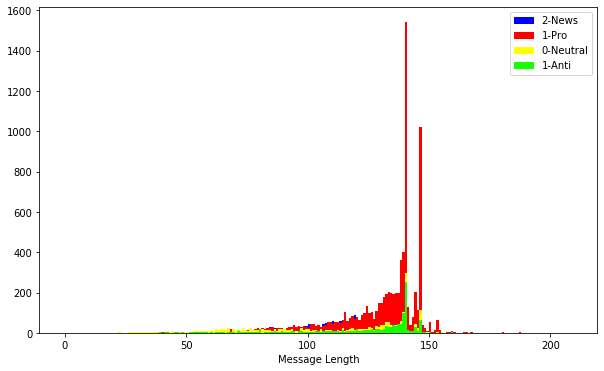

In [ ]:
plt.figure(figsize=(10,6))
nbins = np.arange(0,210)
plt.hist(train[train['sentiment']==2.0]['message_length'],bins=nbins,color="blue")
plt.hist(train[train['sentiment']==1.0]['message_length'],bins=nbins, color="red")
plt.hist(train[train['sentiment']==0.0]['message_length'],bins=nbins, color="yellow")
plt.hist(train[train['sentiment']==-1.0]['message_length'],bins=nbins)
plt.legend(('2-News','1-Pro','0-Neutral','1-Anti'))
#plt.ylabel("Count of messages")
plt.xlabel("Message Length")
plt.show()

Its more likely to pick Pro values that supports the belief of man-made climate change over other sentiments classes

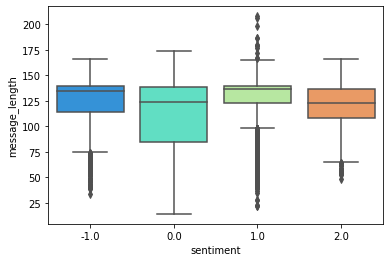

In [ ]:
sns.boxplot(x='sentiment',y='message_length',data=train,palette='rainbow')

Text(0.5, 0, 'Sentiment Class')

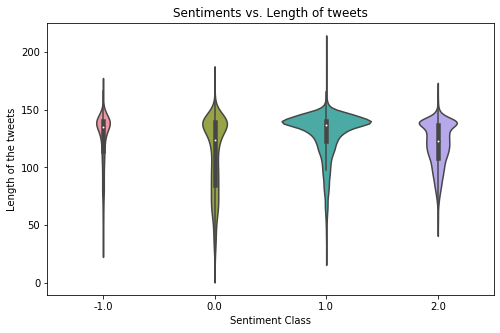

In [ ]:
plt.figure(figsize=(8,5))
plt.title('Sentiments vs. Length of tweets')
sns.violinplot(x='sentiment', y='message_length', data=train,scale='count')
plt.ylabel("Length of the tweets")
plt.xlabel("Sentiment Class")

The seems to be a lot of words (i.e. lengthy tweets) used in class-1. Most tweets are within a range of 130 - 150 words.

### 4.2 Analysis of common words used in the tweets

#### 4.2.1 Word cloud

Now I want to see how well the given sentiments are distributed across the train dataset. One way to accomplish this task is by understanding the common words by plotting wordclouds.

A wordcloud is a visualization wherein the most frequent words appear in large size and the less frequent words appear in smaller sizes.



##### 4.2.1.1 Positive Words

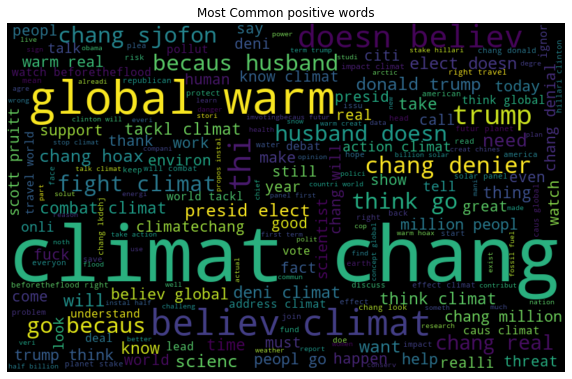

In [ ]:
#visualizing all the positive words in column "tidy_message" in our data using the wordcloud plot.
positive_words =' '.join([text for text in data['tidy_message'][data['sentiment'] == 1]])
from wordcloud import WordCloud
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(positive_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.title("Most Common positive words")
plt.axis('off')
plt.show()

The wordcloud suggests that most positive sentiments are global warming, climate change, believe climate, change real, tackle and the likes depicted in the wordcloud. A strong call for action, to fight climate change by a vast majority of the tweets and a vast majority of people tweeting to others to plea the reality of climate change. 

##### 4.2.1.2 Negative Words

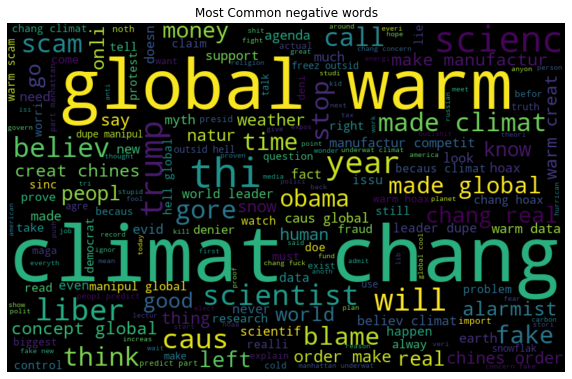

In [ ]:
#visualizing all the negative words in column "tidy_message" in our data using the wordcloud plot.
negative_words = ' '.join([text for text in data['tidy_message'][data['sentiment'] == -1]])
wordcloud = WordCloud(width=800, height=500,
random_state=21, max_font_size=110).generate(negative_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.title("Most Common negative words")
plt.axis('off')
plt.show()

A vast majority of the key words in the negative sentiments are very political and scientific, which indicates a lot of sentimens said by world leaders on the topic of climate change. Trump, a firm anti climate change individual is appearing very significantly, including the terms scientist, made, fake, alarmist which shows either a lot of people not believing that is real on a hunch or because of a lack of scientific evidence to support the claims 

##### 4.2.1.3 Neutrals

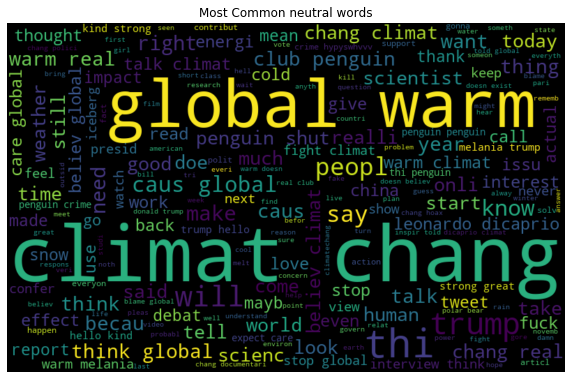

In [ ]:
#visualizing all the neutral words in column "tidy_message" in our data using the wordcloud plot.
normal_words =' '.join([text for text in data['tidy_message'][data['sentiment'] == 0]])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(normal_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.title("Most Common neutral words")
plt.axis('off')
plt.show()

A vast majority of the neutrals are discussing the effects on climate change. They are speaking about the penguins which are indangered due to the effects of climate change. They speak about the climate, weather, warm, polar bear.

##### 4.2.1.4 News

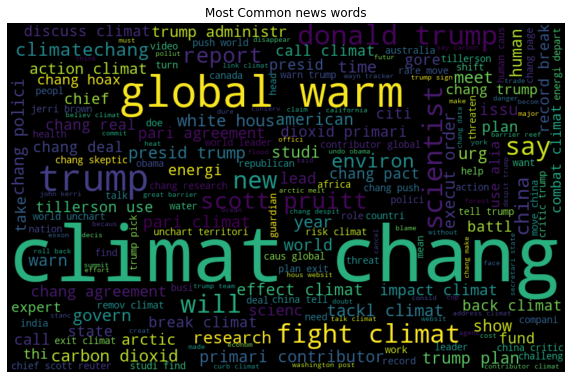

In [ ]:
#visualizing all the news words in column "tidy_message" in our data using the wordcloud plot.
news_words =' '.join([text for text in data['tidy_message'][data['sentiment'] == 2]])

wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(news_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title("Most Common news words")
plt.show()

As we can see, the vast majority of the news is reporting about Donald Trump and his views on climate change. They also report a vast majority of issues all included in the analysis of the other words included. US Administrator of Environmental Affairs is appearing regularly as well. 

4

#### 4.2.2 Hashtags

Hashtags in twitter are synonymous with the ongoing trends on twitter at any particular point in time. We should try to check whether these hashtags add any value to our sentiment analysis task, i.e., they help in distinguishing tweets into the different sentiments.
The tweet seems positive in nature and the hashtags in the tweet convey the same feeling.

In [ ]:
# function to collect hashtags
def hashtag_extract(x):
    hashtags = []
    # Loop over the words in the tweet
    for i in x:
        ht = re.findall(r"#(\w+)", i)
        hashtags.append(ht)

    return hashtags

In [ ]:
# extracting hashtags from the news
HT_news = hashtag_extract(data['tidy_message'][data['sentiment'] == 2])
# extracting hashtags from positive sentiments
HT_positive = hashtag_extract(data['tidy_message'][data['sentiment'] == 1])
# extract hashtags from neutral sentiments
HT_normal = hashtag_extract(data['tidy_message'][data['sentiment'] == 0])
# extracting hashtags from negative sentiments
HT_negative = hashtag_extract(data['tidy_message'][data['sentiment'] == -1])

# unnesting list
HT_news = sum(HT_news,[])
HT_positive = sum(HT_positive,[])
HT_normal = sum(HT_normal,[])
HT_negative = sum(HT_negative,[])

##### 4.2.2.1 News

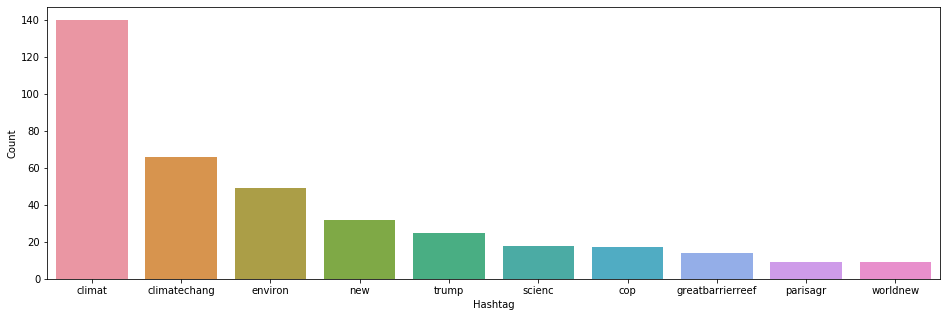

In [ ]:
a = nltk.FreqDist(HT_news)
d = pd.DataFrame({'Hashtag': list(a.keys()),
                  'Count': list(a.values())})
# selecting top 10 most frequent hashtags     
d = d.nlargest(columns="Count", n = 10) 
plt.figure(figsize=(16,5))
ax = sns.barplot(data=d, x= "Hashtag", y = "Count")
ax.set(ylabel = 'Count')
plt.show()

As expected, the news is reporting on a vast nature of stories, mostly around the climate, climate change and the environment

##### 4.2.2.2 Positive hashtags

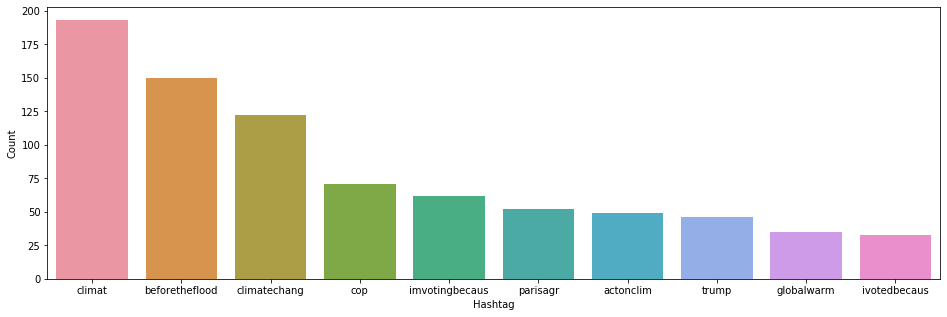

In [ ]:
b = nltk.FreqDist(HT_positive)
e = pd.DataFrame({'Hashtag': list(b.keys()), 'Count': list(b.values())})
# selecting top 10 most frequent hashtags
e = e.nlargest(columns="Count", n = 10)   
plt.figure(figsize=(16,5))
ax = sns.barplot(data=e, x= "Hashtag", y = "Count")
ax.set(ylabel = 'Count')
plt.show()

We find an interesting understanding from this graph. As expected climate is the number one positive key hashtags but what is interesting is number 2, and why Leonardo diCaprio was mentioned on the Wordcloud. Before The Flood is a documentary starring actor Leonardo diCaprio spealing with a lot of activists, scientists and world leaders to discuss climate change and possible solutions. It has clearly had a fantasic response to viewers who have expressed positive feedbank, which proves our assumption that a lot of people need more research and knowledge to believe climate change since seeing is believing. Organisations globally can get involved in similar initiatives which can change the sentiment around climate change. The rest of the positive hashtags come from tweeting about the Conference of Parties (cop) which is a mkeeting by the United nations to discuss climate change. 

##### 4.2.2.3 Neutral hashtags

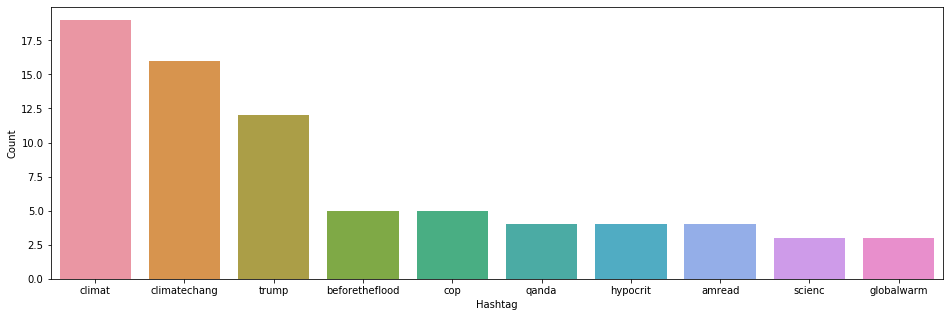

In [ ]:
b = nltk.FreqDist(HT_normal)
e = pd.DataFrame({'Hashtag': list(b.keys()), 'Count': list(b.values())})
# selecting top 10 most frequent hashtags
e = e.nlargest(columns="Count", n = 10)   
plt.figure(figsize=(16,5))
ax = sns.barplot(data=e, x= "Hashtag", y = "Count")
ax.set(ylabel = 'Count')
plt.show()

Climate change and climate are again top of the list, but interestingly enough we start to see the emergance of Trump tweets. Which is driving up the neutrals. We also see the Before The Flood series which our COP, which makes sense since neutrals do question a lot initially and finally the #QandA, which shows a lot of neutral sentiments in the data are questions

##### 4.2.2.4 Negative Hashtags

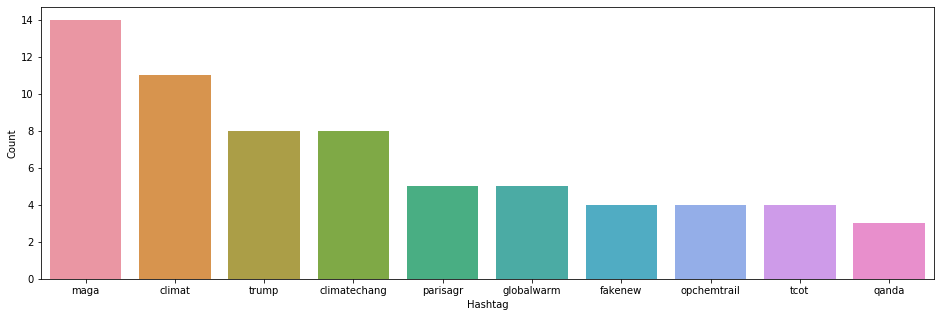

In [ ]:
b = nltk.FreqDist(HT_negative)
e = pd.DataFrame({'Hashtag': list(b.keys()), 'Count': list(b.values())})
# selecting top 10 most frequent hashtags
e = e.nlargest(columns="Count", n = 10)   
plt.figure(figsize=(16,5))
ax = sns.barplot(data=e, x= "Hashtag", y = "Count")
ax.set(ylabel = 'Count')
plt.show()

The number one negative sentiment from the nagative tweets comes from the Make America Great Again campaign by US President Donald Trump. Possibly this indicates all the negative sentiments he has against Climate Change. 

Splitting data

In [ ]:
X = train['tidy_message']
y = train['sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(12655,)
(3164,)
(12655,)
(3164,)


## 5. Model Building

### 5.1 Model building using TF-IDF

In [ ]:
tfidf = TfidfVectorizer()
from sklearn import metrics

In [ ]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()

clf = Pipeline([('tfidf', tfidf), ('clf', model)])


clf.fit(X_train, y_train)

y_pred= clf.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print('f1_score %s' % metrics.f1_score(y_test,y_pred,average='weighted'))
print(classification_report(y_test, y_pred))

accuracy 0.7313527180783818
f1_score 0.713482350529222
              precision    recall  f1-score   support

        -1.0       0.77      0.31      0.45       278
         0.0       0.61      0.37      0.46       425
         1.0       0.75      0.86      0.80      1755
         2.0       0.73      0.78      0.75       706

    accuracy                           0.73      3164
   macro avg       0.71      0.58      0.61      3164
weighted avg       0.73      0.73      0.71      3164



In [ ]:
from sklearn.svm import LinearSVC


classifier = LinearSVC()

clf = Pipeline([('tfidf', tfidf), ('clf', classifier)])

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print('f1_score %s' % metrics.f1_score(y_test,y_pred,average='weighted'))
print(classification_report(y_test, y_pred))

accuracy 0.7240834386852086
f1_score 0.7154479991297034
              precision    recall  f1-score   support

        -1.0       0.65      0.42      0.51       278
         0.0       0.51      0.41      0.46       425
         1.0       0.77      0.83      0.80      1755
         2.0       0.73      0.77      0.75       706

    accuracy                           0.72      3164
   macro avg       0.66      0.61      0.63      3164
weighted avg       0.71      0.72      0.72      3164



In [ ]:
from sklearn.naive_bayes import MultinomialNB

# Naïve Bayes:
clf= Pipeline([('tfidf', tfidf),('clf', MultinomialNB())])

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print('f1_score %s' % metrics.f1_score(y_test,y_pred,average='weighted'))
print(classification_report(y_test, y_pred))

accuracy 0.6280025284450064
f1_score 0.5342252717766514
              precision    recall  f1-score   support

        -1.0       0.50      0.00      0.01       278
         0.0       0.96      0.05      0.10       425
         1.0       0.60      0.99      0.75      1755
         2.0       0.93      0.32      0.47       706

    accuracy                           0.63      3164
   macro avg       0.75      0.34      0.33      3164
weighted avg       0.71      0.63      0.53      3164



### 5.2 Model using Bag of words

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

cf= CountVectorizer()

In [ ]:
from sklearn.naive_bayes import MultinomialNB

# Naïve Bayes:
clf= Pipeline([('cf', cf),('clf', MultinomialNB())])

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print('f1_score %s' % metrics.f1_score(y_test,y_pred,average='weighted'))
print(classification_report(y_test, y_pred))

accuracy 0.7054361567635904
f1_score 0.667499631371626
              precision    recall  f1-score   support

        -1.0       0.91      0.19      0.32       278
         0.0       0.66      0.22      0.33       425
         1.0       0.68      0.92      0.79      1755
         2.0       0.78      0.66      0.72       706

    accuracy                           0.71      3164
   macro avg       0.76      0.50      0.54      3164
weighted avg       0.72      0.71      0.67      3164



In [ ]:
from sklearn.svm import LinearSVC
# Linear SVC:
clf= Pipeline([('cf', cf),('clf',  LinearSVC())])

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print('f1_score %s' % metrics.f1_score(y_test,y_pred,average='weighted'))
print(classification_report(y_test, y_pred))

accuracy 0.7006953223767383
f1_score 0.6984765418838006
              precision    recall  f1-score   support

        -1.0       0.52      0.43      0.47       278
         0.0       0.46      0.46      0.46       425
         1.0       0.77      0.78      0.78      1755
         2.0       0.72      0.74      0.73       706

    accuracy                           0.70      3164
   macro avg       0.62      0.60      0.61      3164
weighted avg       0.70      0.70      0.70      3164



In [ ]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(C=.5)

text_lr= Pipeline([('cf', cf),('clf',model)])

text_lr.fit(X_train, y_train)

y_pred = text_lr.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print('f1_score %s' % metrics.f1_score(y_test,y_pred,average='weighted'))
print(classification_report(y_test, y_pred))

accuracy 0.7310366624525917
f1_score 0.7217513358442864
              precision    recall  f1-score   support

        -1.0       0.71      0.40      0.51       278
         0.0       0.56      0.45      0.50       425
         1.0       0.76      0.84      0.80      1755
         2.0       0.74      0.77      0.75       706

    accuracy                           0.73      3164
   macro avg       0.69      0.61      0.64      3164
weighted avg       0.72      0.73      0.72      3164

